In [62]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import pyflux as pf
from IPython.core.debugger import set_trace
import warnings

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = [15,8]

if os.name=='nt':
    
    dir_farm='//farmnas/FARM/'

else:
    
    dir_farm='//media/farmshare/'
    
dir_pool_dump=dir_farm+'_PoolDump/RUSSELL3000_CONSOLIDATED/LATEST/'

In [2]:
dir_fwd_ret_1d=dir_pool_dump+'FWDReturns/FWD_RelRet-MCWTR_C2C_W1.csv'
df_ret=pd.read_csv(dir_fwd_ret_1d, index_col=0)

In [38]:
ticker='AAPL US Equity'
series=df_ret[ticker].dropna()

## Visualization

t()
2019-02-21    0.429350
2019-02-22    0.611225
2019-02-25    0.211679
2019-02-26    0.254423
2019-02-27   -0.737013
Name: AAPL US Equity, dtype: float64

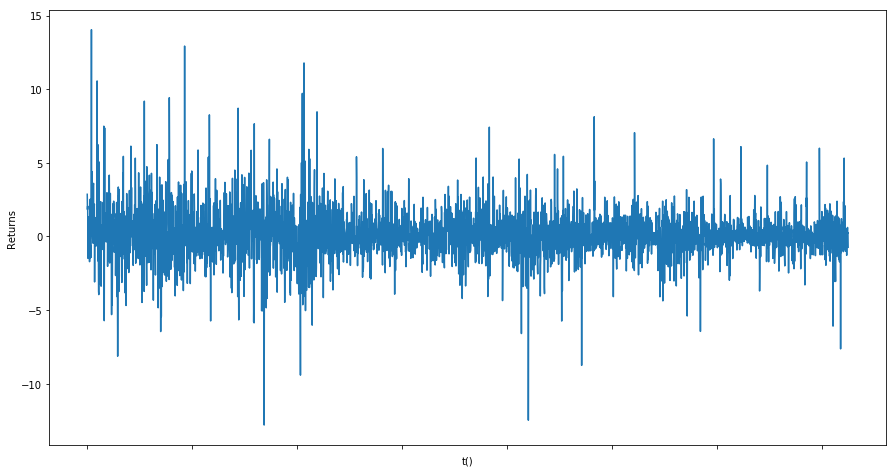

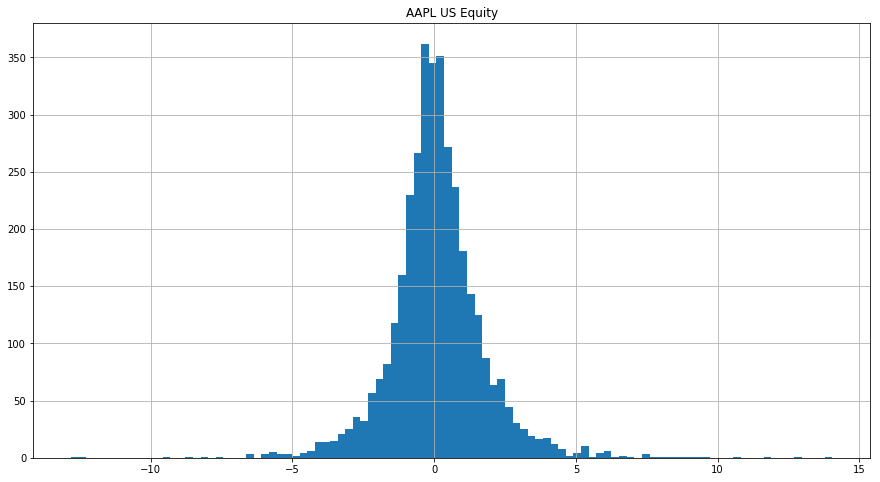

In [29]:
series.plot()
plt.ylabel("Returns")

pd.DataFrame(series).hist(bins=100)
series.tail()

## ADF Test

In [33]:
adf_test=adfuller(series.values)

print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -24.325740
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


## Autocorrelation

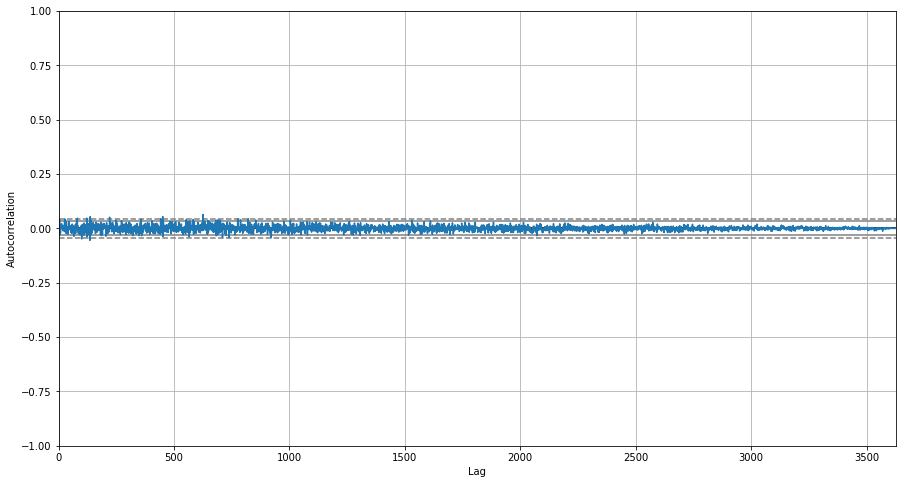

In [34]:
autocorrelation_plot(series)

## ARIMA

                              ARMA Model Results                              
Dep. Variable:         AAPL US Equity   No. Observations:                 3627
Model:                     ARMA(1, 1)   Log Likelihood               -7088.484
Method:                       css-mle   S.D. of innovations              1.708
Date:                Mon, 04 Mar 2019   AIC                          14184.968
Time:                        10:16:44   BIC                          14209.753
Sample:                             0   HQIC                         14193.798
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1004      0.029      3.438      0.001       0.043       0.158
ar.L1.AAPL US Equity    -0.2210      0.280     -0.790      0.430      -0.769       0.327
ma.L1.AAPL U

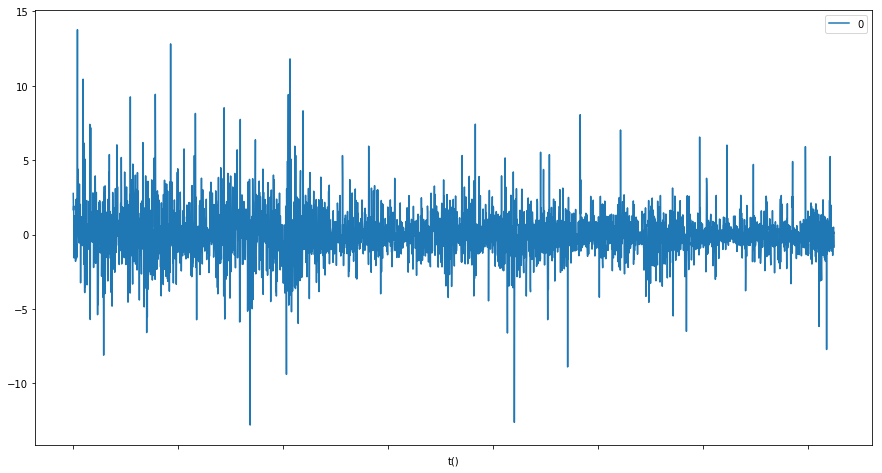

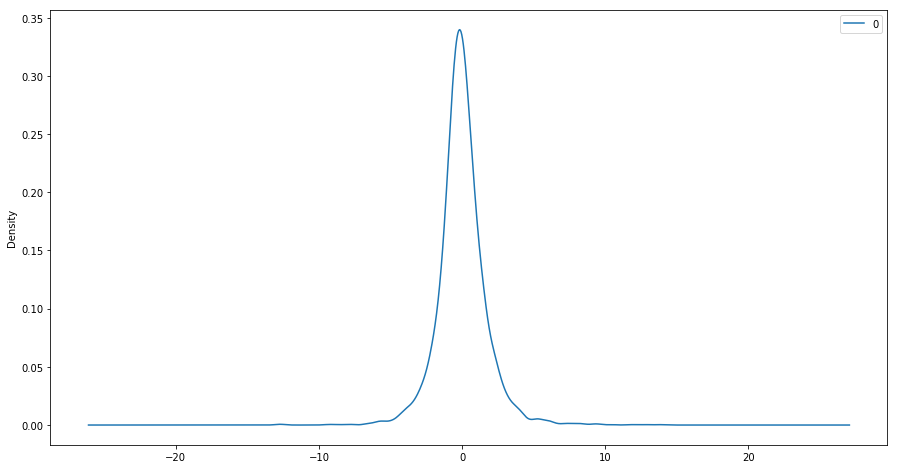

In [41]:
model = ARIMA(series, order=(1,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot() # check any trend remaining
residuals.plot(kind='kde') # check residuals are Gaussian
print(residuals.describe()) # check residual bias

### One-off Forecast

In [59]:
forecast_step=10
df_forecast=pd.DataFrame(model_fit.forecast(forecast_step)[0])
df_forecast.columns=['forecast']
df_forecast['standard error']=model_fit.forecast(forecast_step)[1]
df_forecast['CI_lower']=model_fit.forecast(forecast_step)[2][:,0]
df_forecast['CI_upper']=model_fit.forecast(forecast_step)[2][:,1]

In [60]:
df_forecast

,forecast,standard error,CI_lower,CI_upper
0,0.068392,1.708177,-3.279574,3.416358
1,0.107505,1.709318,-3.242696,3.457707
2,0.098862,1.709374,-3.251449,3.449173
3,0.100772,1.709376,-3.249544,3.451088
4,0.100350,1.709376,-3.249966,3.450666
5,0.100443,1.709376,-3.249873,3.450759
6,0.100422,1.709376,-3.249894,3.450739
7,0.100427,1.709376,-3.249889,3.450743
8,0.100426,1.709376,-3.249890,3.450742
9,0.100426,1.709376,-3.249890,3.450743


### Rolling Fit

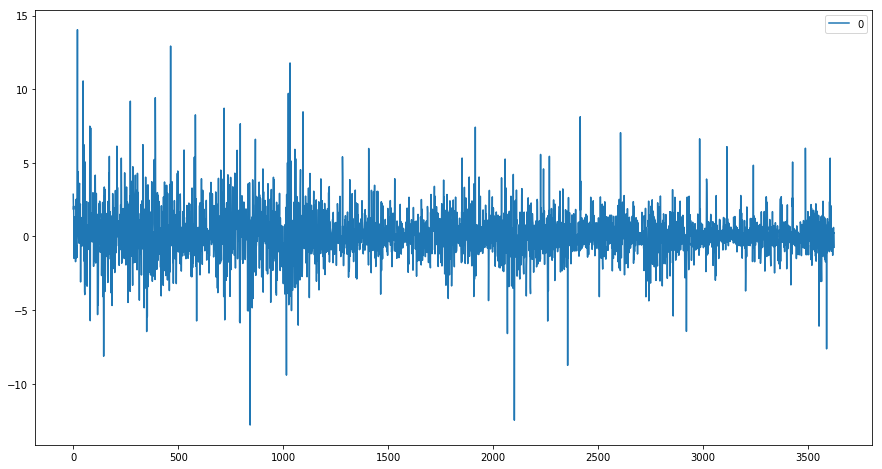

In [69]:
pd.DataFrame(history).plot()

Test MSE: 1.654


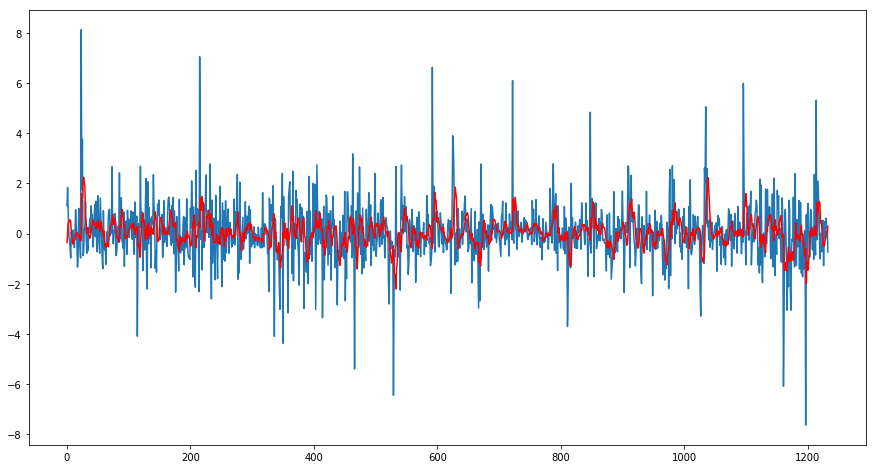

In [64]:
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## Other Models

In [101]:
my_model = pf.GARCH(p=1, q=1, data=df_ret_ticker.dropna().values.T[0])
print(my_model.latent_variables)

Index    Latent Variable           Prior           Prior Hyperparameters     V.I. Dist  Transform 
======== ========================= =============== ========================= ========== ==========
0        Vol Constant              Normal          mu0: 0, sigma0: 3         Normal     exp       
1        q(1)                      Normal          mu0: 0, sigma0: 0.5       Normal     logit     
2        p(1)                      Normal          mu0: 0, sigma0: 0.5       Normal     logit     
3        Returns Constant          Normal          mu0: 0, sigma0: 3         Normal     None      


### Inference

Acceptance rate of Metropolis-Hastings is 0.05425
Acceptance rate of Metropolis-Hastings is 0.24725

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.232625
Acceptance rate of Metropolis-Hastings is 0.3275
GARCH(1,1)                                                                                                
======================================================= ==================================================
Dependent Variable: Series                              Method: Metropolis Hastings                       
Start Date: 1                                           Unnormalized Log Posterior: -6782.8647            
End Date: 3603                                          AIC: 13573.729323888916                           
Number of observations: 3603                            BIC: 13598.487412331908                           
Latent Variable                          Median             Mean               95% Credibility Interval 
=====================

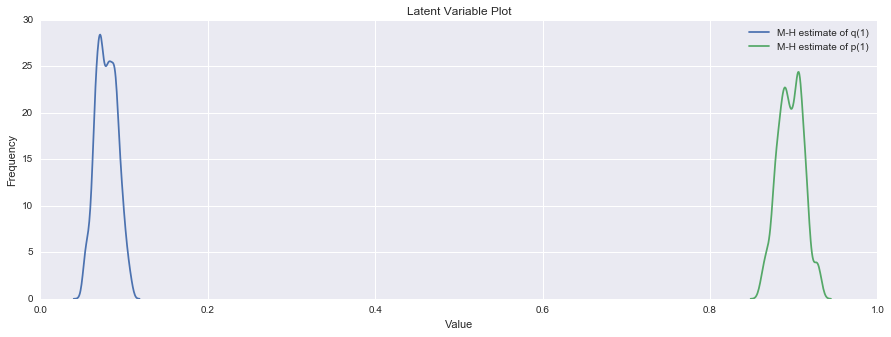

In [106]:
result = my_model.fit('M-H', nsims=2000)
result.summary()

In [ ]:
my_model.plot_z([1,2])

### Evaluate 

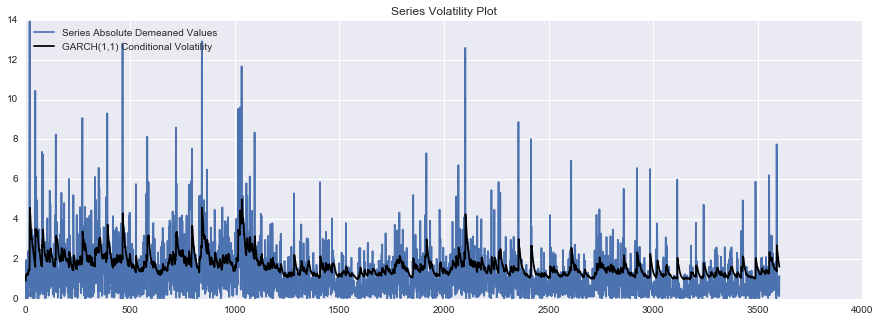

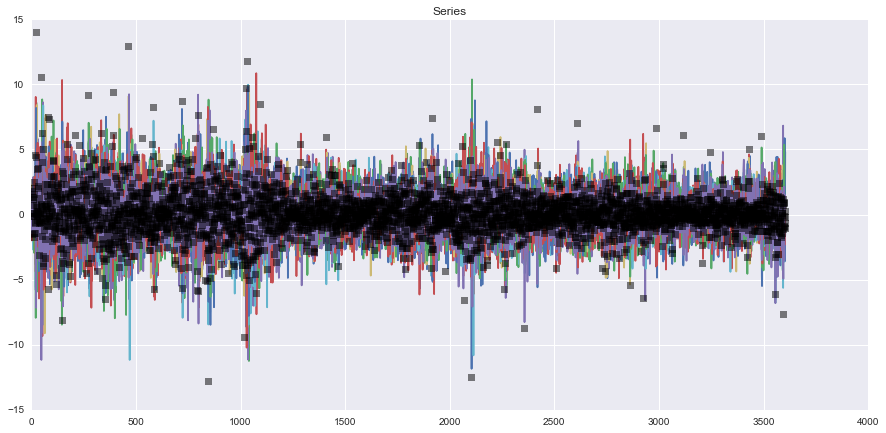

In [103]:
my_model.plot_fit(figsize=(15,5))
my_model.plot_sample(nsims=10, figsize=(15,7))

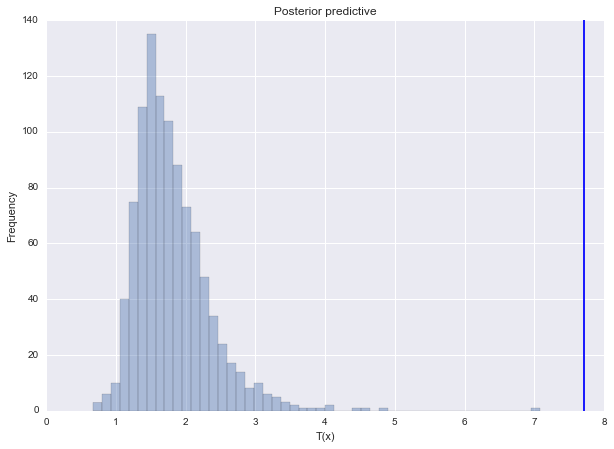

In [105]:
from scipy.stats import kurtosis
my_model.plot_ppc(T=kurtosis)

### Predict

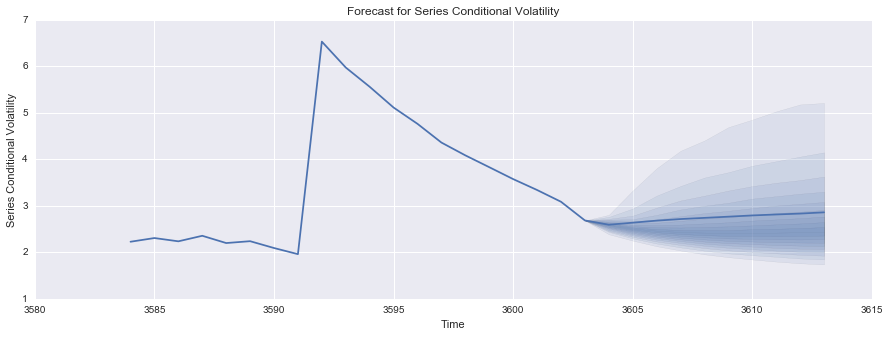

In [107]:
my_model.plot_predict(h=10, figsize=(15,5))

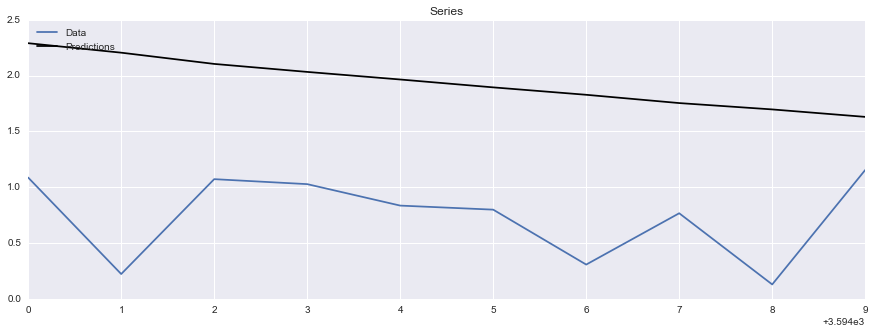

In [108]:
my_model.plot_predict_is(h=10, figsize=(15,5))

In [111]:
predictions = my_model.predict(h=5, intervals=True)